## 程式初始化
Import函數庫

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
import logging

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cpu'

## 實作訓練資料產生函數
宣告公式函數

In [ ]:
def six_hump_camelback(points):
    x = points[:, 0:1] # 0:1而非直接0->確保內部採用Column處理
    y = points[:, 1:2]
    

 
    z = (4 - 2.1 * x**2 + x**4 /3)* x**2 + x * y+ (-4 + 4 * y**2) * y**2  

    return z 

宣告訓練資料產生函數

In [ ]:
def gen_data(Train_num):

    x = np.random.uniform(low=-5, high=5, size=(Train_num,))
    y = np.random.uniform(low=-5, high=5, size=(Train_num,))
    points = np.stack((x,y))
    points = points.reshape(-1,2)
    z = six_hump_camelback(points)
    
    return points, z


設定模型

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Sequential(
                  nn.Linear(2, 20),
                  nn.BatchNorm1d(20),
                  nn.ReLU())
        self.hidden = nn.ModuleList([
                  nn.Sequential(
                    nn.Linear(20, 20),
                    nn.BatchNorm1d(20),
                    nn.ReLU()) for i in range(30)])
        self.output = nn.Linear(20,1)

    def forward(self, x):
        x = self.input(x)
        for module in self.hidden:
          x = module(x)
        x = self.output(x)
        return x

In [ ]:
net = Net()
print(net)

Net(
  (input): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (hidden): ModuleList(
    (0-29): 30 x Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (output): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
def euclidean_distance(y_true, y_pred):
  return torch.sqrt(torch.sum(torch.square(y_true - y_pred)))

## 訓練流程
學習參數



In [ ]:
lr=0.001 # 學習率
loss_fnc = torch.nn.MSELoss()  # 可選擇 'mae', 'mse', 'msle', 'categorical_crossentropy' 或自訂損失函數等...
batchsize = 128 # 批次
epochs = 200 # 
validationsplit = 0.2 # 驗證比例
datanum = 20000

產生訓練集資料

In [ ]:
x_train, y_train = gen_data(datanum)

In [ ]:
train_size = int(0.8 * datanum)
valid_size = datanum - train_size

x_valid = x_train[:valid_size]
y_valid = y_train[:valid_size]
x_train = x_train[valid_size:]
y_train = y_train[valid_size:]

In [ ]:
# transform to torch tensor
tensor_x_train = torch.Tensor(x_train) 
tensor_y_train = torch.Tensor(y_train)
tensor_x_valid = torch.Tensor(x_valid) 
tensor_y_valid = torch.Tensor(y_valid)


# create your datset & DataLoader
train_dataset = TensorDataset(tensor_x_train, tensor_y_train) 
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=False) 
valid_dataset = TensorDataset(tensor_x_valid, tensor_y_valid) 
valid_dataloader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)


In [ ]:
# 確認dataloader
for batch_idx, (data, target) in enumerate(train_dataloader):
  if (batch_idx <1):
    print("data:",data)
    print("target:", target)

data: tensor([[-2.0761, -2.1246],
        [-1.6221, -4.3398],
        [-4.2602,  2.4489],
        [-1.0831,  1.1194],
        [ 3.7168,  4.4232],
        [-0.9332,  4.2880],
        [ 4.1607,  2.6875],
        [ 4.7385,  4.1557],
        [ 2.9163, -3.1219],
        [ 4.0878,  3.9475],
        [ 1.0685,  1.8476],
        [ 4.7328,  4.5162],
        [-4.1901, -2.6837],
        [ 1.6688, -1.3018],
        [-3.2867,  4.8372],
        [ 2.8896, -3.1341],
        [ 1.8208,  1.2617],
        [-4.0613, -4.2316],
        [ 4.2355,  2.9327],
        [-1.0344,  1.6189],
        [ 1.5611, -2.3789],
        [-0.3292,  4.2414],
        [ 1.2213,  4.6528],
        [-1.3433,  0.2064],
        [ 1.3380,  0.4789],
        [-3.8085, -3.1358],
        [ 4.1419, -1.4583],
        [ 3.9595, -0.5903],
        [ 3.7852, -0.4383],
        [-0.0478, -1.9331],
        [-4.0995,  3.4285],
        [-2.6596,  2.3327],
        [ 4.0069,  4.5681],
        [ 1.2169,  3.5439],
        [ 1.0590,  3.7084],
        [-4.07

In [ ]:
# 設定優化器(optimizer)
optimizer = torch.optim.Adam(net.parameters(), lr =lr)


開始訓練

In [ ]:

loss_list = []  
valid_loss_list = []  
for epoch in range(0, epochs):
    train_loss = 0.0
    correct = 0
    net.train()     # Optional when not using Model Specific layer
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        

        optimizer.zero_grad()
        output = net(data)
        loss = euclidean_distance(output,target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        
        # correct += target.eq(labels.view_as(target)).sum().item()
    valid_loss = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for data, labels in valid_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = net(data)
        loss = euclidean_distance(target,labels)
        valid_loss += loss.item() 

    print(f'Epoch {epoch+1} \t Training Loss: {train_loss / train_size} \t  Validation Loss: {valid_loss / valid_size}')
    loss_list.append(train_loss / train_size)
    valid_loss_list.append(valid_loss / valid_size)

Epoch 1 	 Training Loss: 131.40570202636718 	  Validation Loss: 134.649486328125
Epoch 2 	 Training Loss: 131.0988324584961 	  Validation Loss: 134.15135986328124
Epoch 3 	 Training Loss: 130.6320506591797 	  Validation Loss: 133.72598217773438
Epoch 4 	 Training Loss: 130.0677855834961 	  Validation Loss: 133.1303288574219
Epoch 5 	 Training Loss: 129.25685888671876 	  Validation Loss: 131.6502861328125
Epoch 6 	 Training Loss: 128.26748516845703 	  Validation Loss: 131.08717321777343
Epoch 7 	 Training Loss: 127.10290301513672 	  Validation Loss: 129.26749865722655
Epoch 8 	 Training Loss: 125.69949426269531 	  Validation Loss: 128.43869177246094
Epoch 9 	 Training Loss: 124.04840008544922 	  Validation Loss: 126.32139990234376
Epoch 10 	 Training Loss: 122.26492706298828 	  Validation Loss: 125.2806904296875
Epoch 11 	 Training Loss: 120.37294781494141 	  Validation Loss: 123.83430212402344
Epoch 12 	 Training Loss: 118.33726208496094 	  Validation Loss: 120.69951342773437
Epoch 13 

畫loss收斂圖

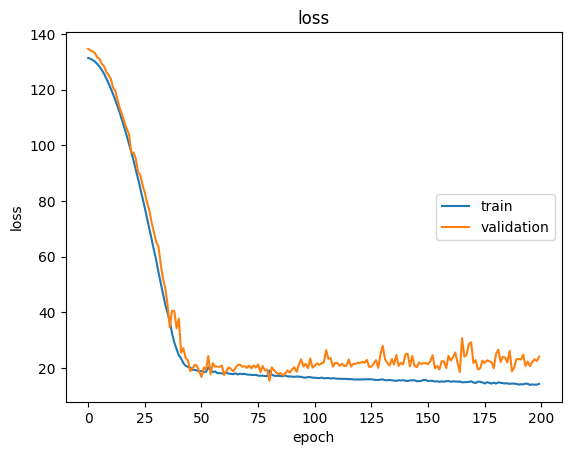

In [ ]:
plt.plot(loss_list)
plt.plot(valid_loss_list)
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='center right')
plt.show()


## 自行測試

In [ ]:
x_test, y_test = gen_data(20)

# transform to torch tensor
tensor_x_test = torch.Tensor(x_test) 
tensor_y_test = torch.Tensor(y_test)


# create your datset & DataLoader
test_dataset = TensorDataset(tensor_x_test, tensor_y_test) 
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False) 

In [ ]:
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        
        # sum up batch loss
        test_loss += euclidean_distance(output, target).item()
        

print('其中三個解:\n')
print(f'\t座標: {data[:3]},\n\t正確解: {target[:3]}\n\t預測解: {output[:3]}\n')

# 平均損失
test_loss /= len(test_dataloader.dataset)
# 顯示測試結果
data_count = len(test_dataloader.dataset)
print(f'平均損失: {test_loss:.4f}')

其中三個解:

	座標: tensor([[-4.2173,  2.9175],
        [-3.9942, -3.7482],
        [-0.0452, -3.1324]]),
	正確解: tensor([[1525.5886],
        [1631.1348],
        [ 345.9950]])
	預測解: tensor([[1329.4943],
        [1664.8613],
        [ 429.7493]])

平均損失: 59.2917
